In [ ]:
!git clone https://github.com/triple-Mu/YOLOv8-TensorRT.git

In [ ]:
!pip install -r YOLOv8-TensorRT/requirements.txt

In [ ]:
!pip install cuda-python tensorrt

In [4]:
import os
os.rename("YOLOv8-TensorRT", "TensorRT")

In [5]:
from TensorRT.models.utils import blob, det_postprocess, letterbox
from TensorRT.models.cudart_api import TRTEngine
from TensorRT.models import EngineBuilder

import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

## Export ONNX -> TensorRT

In [6]:
onnx_model = 'models/face_det.onnx'
device = 'cuda'

builder = EngineBuilder(onnx_model, device)
builder.seg = True
builder.build(fp16=True,
              input_shape=[1, 3, 640, 640],
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

In [1]:
file_size = os.path.getsize('models/face_det.engine')
print("File Size is :", round(file_size/1024**2, 2), "mb")

File Size is : 8.6 mb


In [ ]:
# from ultralytics import YOLO

# model = YOLO('models/face_det.pt')
# model.export(format='onnx')

## Inference TensorRT model

In [7]:
# Non-Maximum Suppression with data processing

def nms(data):
    data = data[0].T
    data = data[np.max(data[:, 4:], axis=1) > 0.3]

    boxes = data[:,:4]
    scores = np.max(data[:, 4:], axis=1)
    cls_idx = np.argmax(data[:, 4:], axis=1)

    boxes /= np.array([in_w, in_h, in_w, in_h])
    boxes *= np.array([im_w, im_h, im_w, im_h])

    boxes[:, 0] = boxes[:, 0] - boxes[:, 2]/2
    boxes[:, 1] = boxes[:, 1] - boxes[:, 3]/2
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.3)[0]
        order = order[inds + 1]

    return boxes[keep], scores[keep], cls_idx[keep]

In [8]:
# read model

Engine = TRTEngine('models/face_det.engine')
in_h, in_w = Engine.inp_info[0].shape[-2:]

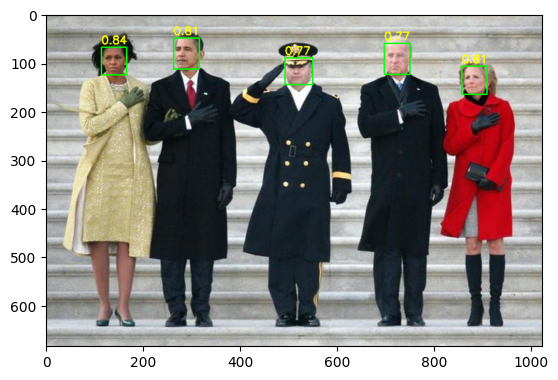

In [9]:
# image predict

image_path = 'test.jpg'
real_img = cv2.imread(image_path)
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
im_h,im_w = real_img.shape[:2]
image = cv2.resize(real_img, (in_w,in_h))
image = np.expand_dims(np.transpose(image, (2, 0, 1)), 0)
image = image.astype(np.float32) / 255.

output_data = Engine(image)[3]

boxes, scores, cls_idx = nms(output_data)

thresh = 0.5
for (box, score, idx) in zip(boxes, scores, cls_idx):
    if score > thresh:

        box = np.round(box).astype(np.int32).tolist()
        score = round(float(score), 2)

        cv2.rectangle(real_img, box[:2], box[2:], (0,255,0), 2)
        cv2.putText(real_img, str(score), (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [255, 255, 0], thickness=2)

plt.imshow(real_img)
plt.show()

In [ ]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened()== False):
    print("Error opening video file")

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        real_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_h,im_w = real_img.shape[:2]
        image = cv2.resize(real_img, (in_w,in_h))
        image = np.expand_dims(np.transpose(image, (2, 0, 1)), 0)
        image = image.astype(np.float32) / 255.

        output_data = Engine(image)[3]
        boxes, scores, cls_idx = nms(output_data)

        thresh = 0.5
        for (box, score, idx) in zip(boxes, scores, cls_idx):
            if score > thresh:

                box = np.round(box).astype(np.int32).tolist()
                score = round(float(score), 2)

                cv2.rectangle(frame, box[:2], box[2:], (0,255,0), 2)
                cv2.putText(frame, str(score), (box[0], box[1] - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [0, 255, 255], thickness=2)

        cv2.imshow(frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()